In [2]:
import json
import random
from tqdm.auto import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [3]:
!wget https://github.com/semensorokin/DL_for_NLP_2021/blob/master/homework2/data/corpus.json.zip?raw=true

--2020-11-11 17:36:42--  https://github.com/semensorokin/DL_for_NLP_2021/blob/master/homework2/data/corpus.json.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/semensorokin/DL_for_NLP_2021/raw/master/homework2/data/corpus.json.zip [following]
--2020-11-11 17:36:42--  https://github.com/semensorokin/DL_for_NLP_2021/raw/master/homework2/data/corpus.json.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/semensorokin/DL_for_NLP_2021/master/homework2/data/corpus.json.zip [following]
--2020-11-11 17:36:43--  https://raw.githubusercontent.com/semensorokin/DL_for_NLP_2021/master/homework2/data/corpus.json.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to

In [4]:
!unzip corpus.json.zip?raw=true

Archive:  corpus.json.zip?raw=true
  inflating: corpus.json             
   creating: __MACOSX/
  inflating: __MACOSX/._corpus.json  


In [5]:
with open('/content/corpus.json') as f: 
    corpus = json.load(f)

In [6]:
len(corpus)

1157366

In [ ]:
for text in corpus[:10]:
    print(' '.join(text))

оказалось для пользовании этой услугой банку нужно предоставить фото отчет накладных и магазина склада
затем эквайринг разблокировали но тут начинается самое веселое мне выставляют счет за пользование нерабочим экварингом
##число фз о исполнительном производстве банк заблокировал денежные средства счет и кредитный лимит
##число фз о исполнительном производстве блокируются денежные средства а не счёт банку не известно
курьер перезыонил мне через некоторое время и сообщил что по заявке было принято отрицательное решение
как так могло произойти что у меня на руках подписанный договор а решение было отрицательное
##число у меня ##число карты часто бывает что по одной операции проходят а по второй нет
каждый месяц вношу платёж по кредитной карте через голосовое меню восточного банка
по сообщению от банка я обязана была внести сумму до ##число включительно
но проснувшись ##число май пришла смс о том что у меня просрочка ##число рублей


In [ ]:
for text in corpus[:5]:
    print(' '.join(text))

оказалось для пользовании этой услугой банку нужно предоставить фото отчет накладных и магазина склада
затем эквайринг разблокировали но тут начинается самое веселое мне выставляют счет за пользование нерабочим экварингом
##число фз о исполнительном производстве банк заблокировал денежные средства счет и кредитный лимит
##число фз о исполнительном производстве блокируются денежные средства а не счёт банку не известно
курьер перезыонил мне через некоторое время и сообщил что по заявке было принято отрицательное решение


# Препроцессинг текста (скопировано из тетерадки

In [8]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 8.2MB 5.3MB/s 


In [13]:
import json
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
morph = MorphAnalyzer()

def get_lemma(word):
    
    word_data = morph.parse(word)[0]
    
    return word_data.normal_form

In [11]:
tok2lemma = {}

for text in tqdm(corpus):
    for tok in text:
        if tok not in tok2lemma:
            tok2lemma[tok] = get_lemma(tok)

100%|██████████| 1157366/1157366 [00:42<00:00, 27161.94it/s]


In [14]:
stopwords = nltk.corpus.stopwords.words('russian')

In [15]:
lemmas_corpus = [[tok2lemma[tok] for tok in text if tok not in stopwords and tok] for text in tqdm(corpus)]

100%|██████████| 1157366/1157366 [00:28<00:00, 39939.00it/s]


In [16]:
freq = {}

for text in tqdm(lemmas_corpus):
    for tok in text:
        if tok in freq:
            freq[tok] += 1
        else:
            freq[tok] = 1

100%|██████████| 1157366/1157366 [00:03<00:00, 315070.30it/s]


In [18]:
freq_df = pd.DataFrame(data={'word': list(freq.keys()), 
                             'n_entries': list(freq.values())})
freq_df.shape

(76916, 2)

In [19]:
n_words = freq_df.n_entries.sum()

In [20]:
print('Доля слов, которые мы заменим на UNK:')

for threshold in np.arange(5, 36, 5):
    
    sub_df = freq_df[freq_df.n_entries < threshold]
    
    unk_freq = sub_df['n_entries'].sum() * 100 / n_words
    
    print('Порог отсечения - {}, доля UNK - {:.2f} %, слов в слове - {}, удалили - {} слов'.format(
        threshold, unk_freq, freq_df.shape[0] - sub_df.shape[0], sub_df.shape[0]))

Доля слов, которые мы заменим на UNK:
Порог отсечения - 5, доля UNK - 0.76 %, слов в слове - 23307, удалили - 53609 слов
Порог отсечения - 10, доля UNK - 1.18 %, слов в слове - 16771, удалили - 60145 слов
Порог отсечения - 15, доля UNK - 1.51 %, слов в слове - 13782, удалили - 63134 слов
Порог отсечения - 20, доля UNK - 1.81 %, слов в слове - 11946, удалили - 64970 слов
Порог отсечения - 25, доля UNK - 2.07 %, слов в слове - 10737, удалили - 66179 слов
Порог отсечения - 30, доля UNK - 2.30 %, слов в слове - 9835, удалили - 67081 слов
Порог отсечения - 35, доля UNK - 2.52 %, слов в слове - 9135, удалили - 67781 слов


In [21]:
# кажется, что оптимально, но обычно берут меньше
threshold = 15
vocab = freq_df[freq_df.n_entries >= threshold]
words = set(vocab.word)
len(words)

13782

In [22]:
def get_correct_words(word):
    
    if word in words:
        return word
    else:
        return 'UNK'

In [23]:
# заменим слово токеном UNK, если его нет в нашем новом словаре
processed_corpus = [[get_correct_words(tok) for tok in text] for text in tqdm(lemmas_corpus)]

100%|██████████| 1157366/1157366 [00:05<00:00, 210698.74it/s]


In [24]:
def drop_duplicate_unks(tokens):
    
    output_tokens = []
    
    for tok in tokens:
        
        if tok == 'UNK' and output_tokens and output_tokens[-1] == 'UNK':
            continue
            
        output_tokens.append(tok)
            
    return output_tokens

In [25]:
# дедублируем подряд идущие унки (оставим только один)
processed_corpus = [drop_duplicate_unks(sample) for sample in tqdm(processed_corpus)]

100%|██████████| 1157366/1157366 [00:03<00:00, 325634.48it/s]


In [26]:
random.shuffle(processed_corpus)

In [27]:
sub_data = processed_corpus[:100000]

In [35]:
with open('/content/processed_corpus.json', 'w') as f:
    json.dump(sub_data, f, ensure_ascii=False)

# CBOW

In [37]:
!wget https://raw.githubusercontent.com/polyankaglade/networks_2020/main/HW2/processed_corpus.json

--2020-11-11 17:57:36--  https://raw.githubusercontent.com/polyankaglade/networks_2020/main/HW2/processed_corpus.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15909694 (15M) [text/plain]
Saving to: ‘processed_corpus.json’

processed_corpus.js 100%[===================>]  15.17M  24.2MB/s    in 0.6s    

2020-11-11 17:57:37 (24.2 MB/s) - ‘processed_corpus.json’ saved [15909694/15909694]



In [38]:
with open('/content/processed_corpus.json') as f: 
    corpus = json.load(f)

# Реализуйте разделение предложения на примеры методом CBOW

In [17]:
with open('processed_corpus.json', encoding='utf-8') as f: 
    corpus = json.load(f)

In [18]:
sample_text = corpus[1]

In [19]:
' '.join(sample_text)

'яндекс такси всё понятно непонятно почему такой организация существовать'

In [20]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    # CODE
    padding = [pad_token]*window
    full_text = padding + tokens + padding

    for i, _ in enumerate(tokens):
       left = full_text[i:i+window]
       word = full_text[i+window]
       right = full_text[i+window+1:i+window+1+window]

       splits.append((left, word, right))
        
    return splits

In [21]:
splits = cbow_split(sample_text, window=2)

In [22]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: яндекс
Правый контекст: ['такси', 'всё']

Левый контекст: ['PAD', 'яндекс']
Центральное слово: такси
Правый контекст: ['всё', 'понятно']

Левый контекст: ['яндекс', 'такси']
Центральное слово: всё
Правый контекст: ['понятно', 'непонятно']

Левый контекст: ['такси', 'всё']
Центральное слово: понятно
Правый контекст: ['непонятно', 'почему']

Левый контекст: ['всё', 'понятно']
Центральное слово: непонятно
Правый контекст: ['почему', 'такой']

Левый контекст: ['понятно', 'непонятно']
Центральное слово: почему
Правый контекст: ['такой', 'организация']

Левый контекст: ['непонятно', 'почему']
Центральное слово: такой
Правый контекст: ['организация', 'существовать']

Левый контекст: ['почему', 'такой']
Центральное слово: организация
Правый контекст: ['существовать', 'PAD']

Левый контекст: ['такой', 'организация']
Центральное слово: существовать
Правый контекст: ['PAD', 'PAD']



In [23]:
splits

[(['PAD', 'PAD'], 'яндекс', ['такси', 'всё']),
 (['PAD', 'яндекс'], 'такси', ['всё', 'понятно']),
 (['яндекс', 'такси'], 'всё', ['понятно', 'непонятно']),
 (['такси', 'всё'], 'понятно', ['непонятно', 'почему']),
 (['всё', 'понятно'], 'непонятно', ['почему', 'такой']),
 (['понятно', 'непонятно'], 'почему', ['такой', 'организация']),
 (['непонятно', 'почему'], 'такой', ['организация', 'существовать']),
 (['почему', 'такой'], 'организация', ['существовать', 'PAD']),
 (['такой', 'организация'], 'существовать', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [24]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'яндекс', ['такси', 'всё', 'понятно']),
 (['PAD', 'PAD', 'яндекс'], 'такси', ['всё', 'понятно', 'непонятно']),
 (['PAD', 'яндекс', 'такси'], 'всё', ['понятно', 'непонятно', 'почему']),
 (['яндекс', 'такси', 'всё'], 'понятно', ['непонятно', 'почему', 'такой']),
 (['такси', 'всё', 'понятно'],
  'непонятно',
  ['почему', 'такой', 'организация']),
 (['всё', 'понятно', 'непонятно'],
  'почему',
  ['такой', 'организация', 'существовать']),
 (['понятно', 'непонятно', 'почему'],
  'такой',
  ['организация', 'существовать', 'PAD']),
 (['непонятно', 'почему', 'такой'],
  'организация',
  ['существовать', 'PAD', 'PAD']),
 (['почему', 'такой', 'организация'], 'существовать', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [25]:
' '.join(sample_text)

'яндекс такси всё понятно непонятно почему такой организация существовать'

# Реализуйте разделение предложения на примеры методом Skipgram

In [26]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    l = len(tokens)
    for i, word in enumerate(tokens):
        start = max(i-window, 0)
        end = min(i+window+1, l-1)

        # while True:
        #     try:
        #         left = tokens[start:i]
        #         break
        #     except IndexError:
        #         start += 1
        # while True:
        #     try:
        #         right = tokens[i+1:end]
        #         break
        #     except IndexError:
        #         end -= 1
        
        left = tokens[start:i]
        right = tokens[i+1:end]
        for context in left+right:
            splits.append((context, word))
    
    return splits

In [27]:
splits = skipgram_split(sample_text, window=2)

In [28]:
splits

[('такси', 'яндекс'),
 ('всё', 'яндекс'),
 ('яндекс', 'такси'),
 ('всё', 'такси'),
 ('понятно', 'такси'),
 ('яндекс', 'всё'),
 ('такси', 'всё'),
 ('понятно', 'всё'),
 ('непонятно', 'всё'),
 ('такси', 'понятно'),
 ('всё', 'понятно'),
 ('непонятно', 'понятно'),
 ('почему', 'понятно'),
 ('всё', 'непонятно'),
 ('понятно', 'непонятно'),
 ('почему', 'непонятно'),
 ('такой', 'непонятно'),
 ('понятно', 'почему'),
 ('непонятно', 'почему'),
 ('такой', 'почему'),
 ('организация', 'почему'),
 ('непонятно', 'такой'),
 ('почему', 'такой'),
 ('организация', 'такой'),
 ('почему', 'организация'),
 ('такой', 'организация'),
 ('такой', 'существовать'),
 ('организация', 'существовать')]

In [29]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: такси
Центральное слово: яндекс

Контекст: всё
Центральное слово: яндекс

Контекст: яндекс
Центральное слово: такси

Контекст: всё
Центральное слово: такси

Контекст: понятно
Центральное слово: такси

Контекст: яндекс
Центральное слово: всё

Контекст: такси
Центральное слово: всё

Контекст: понятно
Центральное слово: всё

Контекст: непонятно
Центральное слово: всё

Контекст: такси
Центральное слово: понятно

Контекст: всё
Центральное слово: понятно

Контекст: непонятно
Центральное слово: понятно

Контекст: почему
Центральное слово: понятно

Контекст: всё
Центральное слово: непонятно

Контекст: понятно
Центральное слово: непонятно

Контекст: почему
Центральное слово: непонятно

Контекст: такой
Центральное слово: непонятно

Контекст: понятно
Центральное слово: почему

Контекст: непонятно
Центральное слово: почему

Контекст: такой
Центральное слово: почему

Контекст: организация
Центральное слово: почему

Контекст: непонятно
Центральное слово: такой

Контекст: почему
Центральное

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [30]:
skipgram_split(sample_text, window=3)

[('такси', 'яндекс'),
 ('всё', 'яндекс'),
 ('понятно', 'яндекс'),
 ('яндекс', 'такси'),
 ('всё', 'такси'),
 ('понятно', 'такси'),
 ('непонятно', 'такси'),
 ('яндекс', 'всё'),
 ('такси', 'всё'),
 ('понятно', 'всё'),
 ('непонятно', 'всё'),
 ('почему', 'всё'),
 ('яндекс', 'понятно'),
 ('такси', 'понятно'),
 ('всё', 'понятно'),
 ('непонятно', 'понятно'),
 ('почему', 'понятно'),
 ('такой', 'понятно'),
 ('такси', 'непонятно'),
 ('всё', 'непонятно'),
 ('понятно', 'непонятно'),
 ('почему', 'непонятно'),
 ('такой', 'непонятно'),
 ('организация', 'непонятно'),
 ('всё', 'почему'),
 ('понятно', 'почему'),
 ('непонятно', 'почему'),
 ('такой', 'почему'),
 ('организация', 'почему'),
 ('понятно', 'такой'),
 ('непонятно', 'такой'),
 ('почему', 'такой'),
 ('организация', 'такой'),
 ('непонятно', 'организация'),
 ('почему', 'организация'),
 ('такой', 'организация'),
 ('почему', 'существовать'),
 ('такой', 'существовать'),
 ('организация', 'существовать')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [31]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [32]:
len(word2index)

13038

In [33]:
word2index['UNK']

21

In [34]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[2479, 8477, 21]

# Torch Dataset
В торче есть очень удобная читалка данных

In [35]:
from torch.utils.data import Dataset, DataLoader

In [36]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [37]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.48865125, 0.57598784, 0.803654  , 0.97313404],
       [0.40928422, 0.75809782, 0.39248033, 0.60604954],
       [0.58260856, 0.03415962, 0.90909636, 0.53672591],
       [0.57237912, 0.99284002, 0.63788297, 0.72827724],
       [0.8448034 , 0.82413802, 0.3357151 , 0.79510248],
       [0.56067836, 0.62673416, 0.14338405, 0.62978163],
       [0.72131354, 0.69808182, 0.2782476 , 0.36004135],
       [0.56516142, 0.68513805, 0.36857986, 0.28762641],
       [0.23665928, 0.17268541, 0.68745176, 0.70702136],
       [0.29370406, 0.1007655 , 0.13350264, 0.87464599]])

In [38]:
some_data_y

array([1, 2, 2, ..., 0, 1, 0])

In [39]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [40]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [41]:
some_dataset[5], some_dataset[467]

((array([0.56067836, 0.62673416, 0.14338405, 0.62978163]), 1),
 (array([0.73669428, 0.78382817, 0.17647677, 0.97810057]), 2))

In [42]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [43]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.4612, 0.5488, 0.7611, 0.7170],
         [0.6831, 0.7834, 0.4850, 0.0098],
         [0.4403, 0.1787, 0.9570, 0.8703],
         [0.9498, 0.0519, 0.2378, 0.6069],
         [0.3192, 0.4415, 0.9666, 0.4244],
         [0.8438, 0.6341, 0.3566, 0.8957],
         [0.0579, 0.3872, 0.3549, 0.1598],
         [0.1104, 0.1241, 0.2010, 0.4146],
         [0.9629, 0.6017, 0.2616, 0.1337],
         [0.5448, 0.6199, 0.3947, 0.0523],
         [0.5591, 0.3032, 0.4210, 0.2846],
         [0.8543, 0.5565, 0.2905, 0.8901],
         [0.1801, 0.2354, 0.4420, 0.5956],
         [0.9453, 0.9557, 0.7348, 0.0977],
         [0.9544, 0.6626, 0.8130, 0.8396],
         [0.0943, 0.3227, 0.6657, 0.7791]], dtype=torch.float64))

In [44]:
for x, y in some_loader:
    pass

len(x)

15

In [45]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [46]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [47]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [48]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [49]:
for x, y in toy_loader:
    break

In [50]:
x.shape

torch.Size([128, 32])

In [51]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.4887,   0.5760,   0.8037,  ...,  -3.3100,  -1.3115,  -0.1634],
        [  0.4093,   0.7581,   0.3925,  ...,  -1.6617,  -5.6116,  -3.0048],
        [  0.5826,   0.0342,   0.9091,  ..., -20.2603,  -0.5718,  -3.7336],
        ...,
        [  0.3427,   0.9625,   0.9692,  ...,  -0.2295,  -0.1878,  -8.8491],
        [  0.6737,   0.3505,   0.4386,  ...,  -6.2902,  -4.9453,  -2.4675],
        [  0.0452,   0.9798,   0.6172,  ...,  -0.1224,  -2.8952,  -0.3265]],
       dtype=torch.float64)

In [52]:
y

tensor([1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 0, 1, 0, 2, 0, 2,
        2, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 0, 0, 2, 2,
        2, 2, 1, 1, 1, 0, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 0, 0, 1, 2, 2, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 2, 1,
        2, 2, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 1, 1, 2, 1, 2, 0, 0, 1,
        2, 1, 0, 2, 0, 1, 2, 1], dtype=torch.int32)

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [53]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [55]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y.long())
    
loss.item()

1.1383029222488403

# Боевые датасеты

In [56]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [57]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которые вы писали раньше

        splits = []

        l = len(tokenized_text)
        for i, word in enumerate(tokenized_text):
            start = max(i-self.window, 0)
            end = min(i+self.window+1, l-1)

            # while True:
            #     try:
            #         left = tokens[start:i]
            #         break
            #     except IndexError:
            #         start += 1
            # while True:
            #     try:
            #         right = tokens[i+1:end]
            #         break
            #     except IndexError:
            #         end -= 1
            
            left = tokenized_text[start:i]
            right = tokenized_text[i+1:end]
            for context in left+right:
                splits.append((context, word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]
        #context = torch.Tensor(context).long()

        return context, central_word

In [58]:
dataset = SkipgramDataset(corpus, word2index)

In [59]:
BATCH_SIZE = 512

In [60]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [61]:
for x, y in dataset_loader:
    break

In [62]:
x[:5]

tensor([ 748,  252, 1054,   23, 1023])

In [63]:
y[:5]

tensor([ 112, 5790,  641,  887,  983])

In [64]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [65]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [66]:
# CODE
class SkipGram(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [67]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [68]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [70]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13038])

In [71]:
pred

tensor([[ 0.1753, -0.8121, -0.4549,  ...,  0.1794,  0.0070,  0.2040],
        [ 0.0064, -0.1958, -0.5930,  ..., -0.0137,  0.1130,  0.7726],
        [ 0.6201, -0.0579,  0.0158,  ...,  0.1466,  0.1445,  0.2474],
        ...,
        [ 0.4531, -0.1106, -0.1440,  ..., -0.2577,  0.3003,  0.3727],
        [-0.9020,  0.5894, -0.2132,  ..., -0.2407,  0.5634, -0.0986],
        [-1.4432,  0.3830, -0.7809,  ..., -1.8628, -0.0433,  0.3689]])

In [72]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [73]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            
            pred = model(x)

            loss = criterion(pred, y)
            
            # CODE
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

```
100% 2780217/2780217 [16:25<00:00, 2819.95it/s, loss=7.42]
100% 2780217/2780217 [16:27<00:00, 2814.06it/s, loss=7.3]
100% 2780217/2780217 [16:43<00:00, 2770.27it/s, loss=7.14]
```

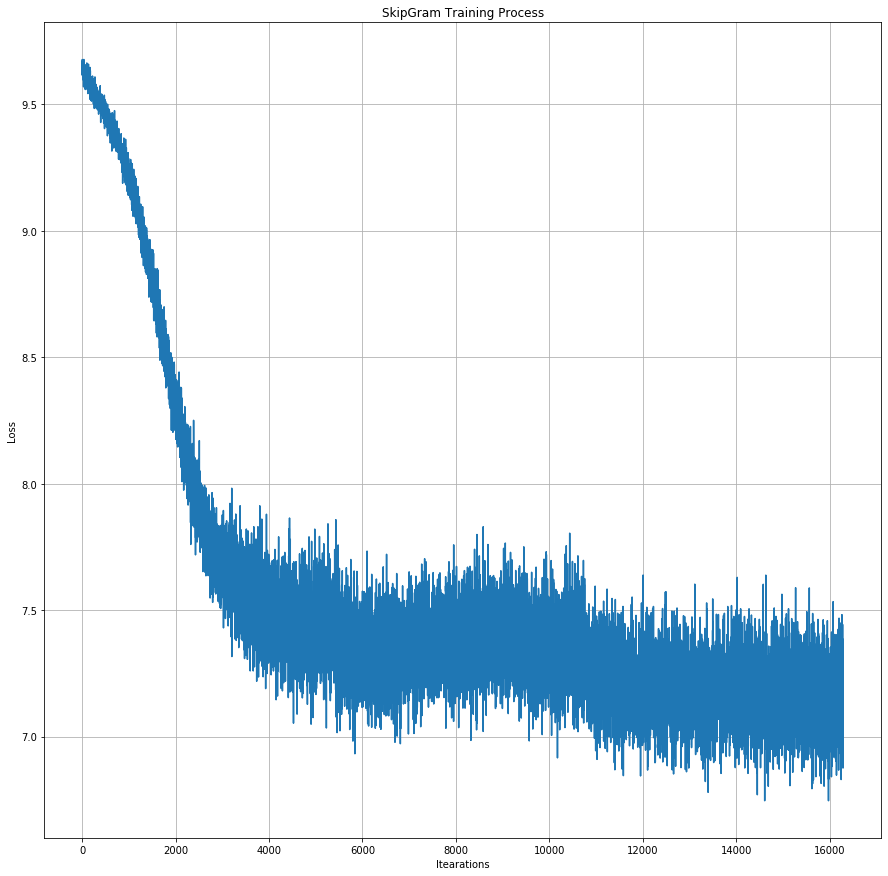

In [74]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

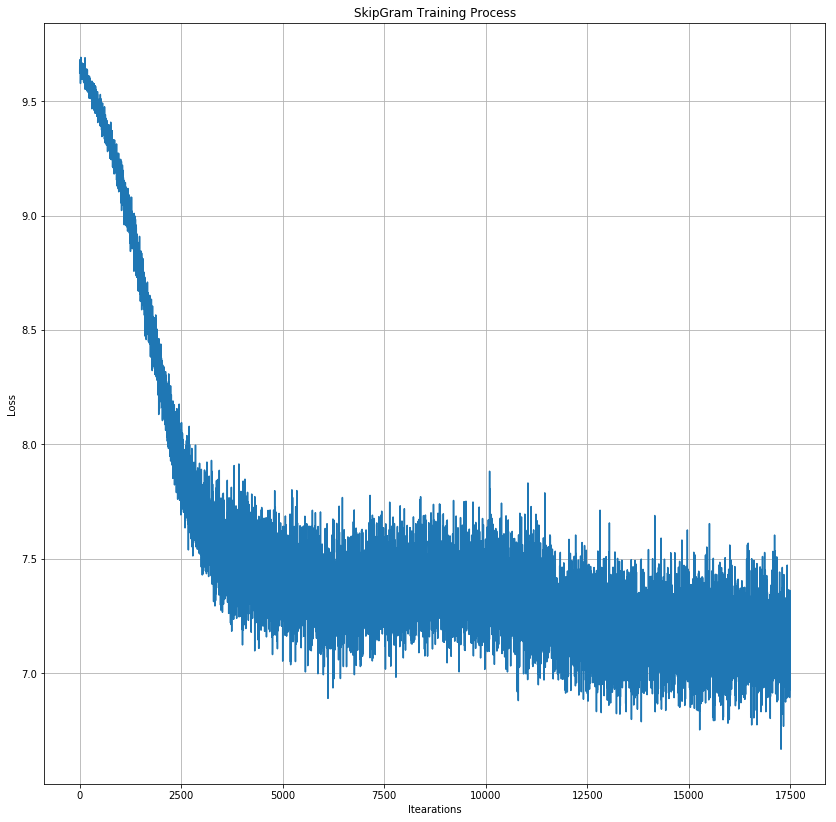

In [ ]:
# из оригинальной тетрадки

plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [75]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [76]:
embedding_matrix = model.in_embedding.weight.detach()

In [77]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [78]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.7116082310676575

In [79]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.7589919567108154

In [80]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.6620911955833435

In [81]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.7472051382064819

In [82]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "ижевск" равна 0.588'

In [83]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [84]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [85]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13038 samples in 0.077s...
[t-SNE] Computed neighbors for 13038 samples in 6.949s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13038
[t-SNE] Computed conditional probabilities for sample 2000 / 13038
[t-SNE] Computed conditional probabilities for sample 3000 / 13038
[t-SNE] Computed conditional probabilities for sample 4000 / 13038
[t-SNE] Computed conditional probabilities for sample 5000 / 13038
[t-SNE] Computed conditional probabilities for sample 6000 / 13038
[t-SNE] Computed conditional probabilities for sample 7000 / 13038
[t-SNE] Computed conditional probabilities for sample 8000 / 13038
[t-SNE] Computed conditional probabilities for sample 9000 / 13038
[t-SNE] Computed conditional probabilities for sample 10000 / 13038
[t-SNE] Computed conditional probabilities for sample 11000 / 13038
[t-SNE] Computed conditional probabilities for sample 12000 / 13038
[t-SNE] Computed conditional probabilities for sam

In [87]:
top_words = [a for a,_ in top_sorted_freq]

In [88]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

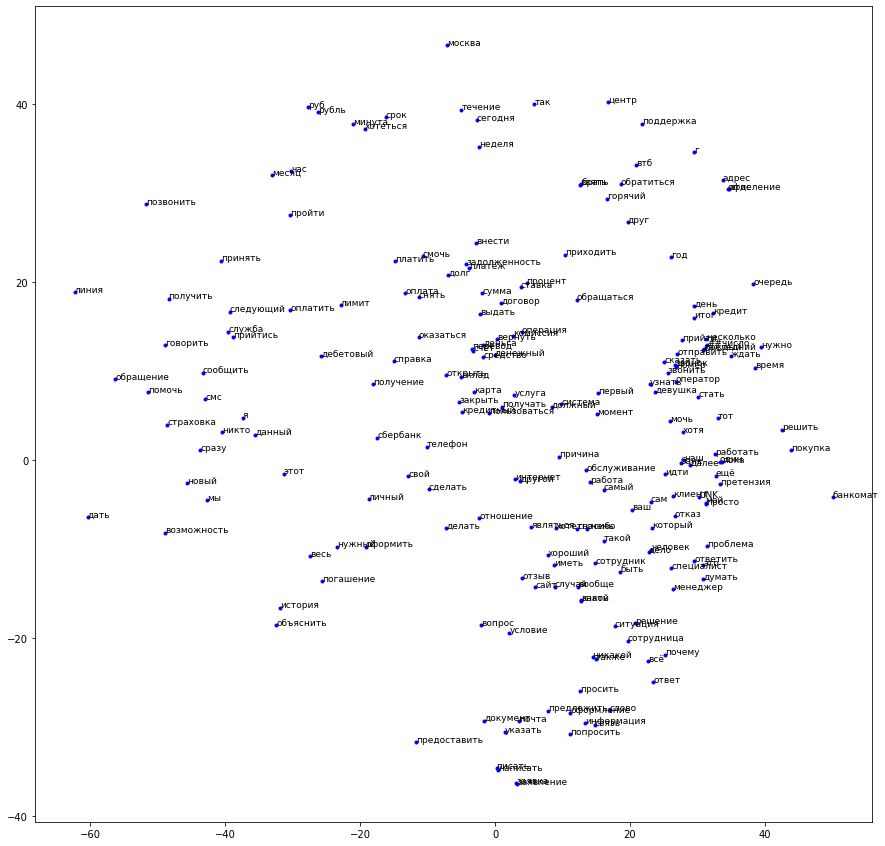

In [89]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

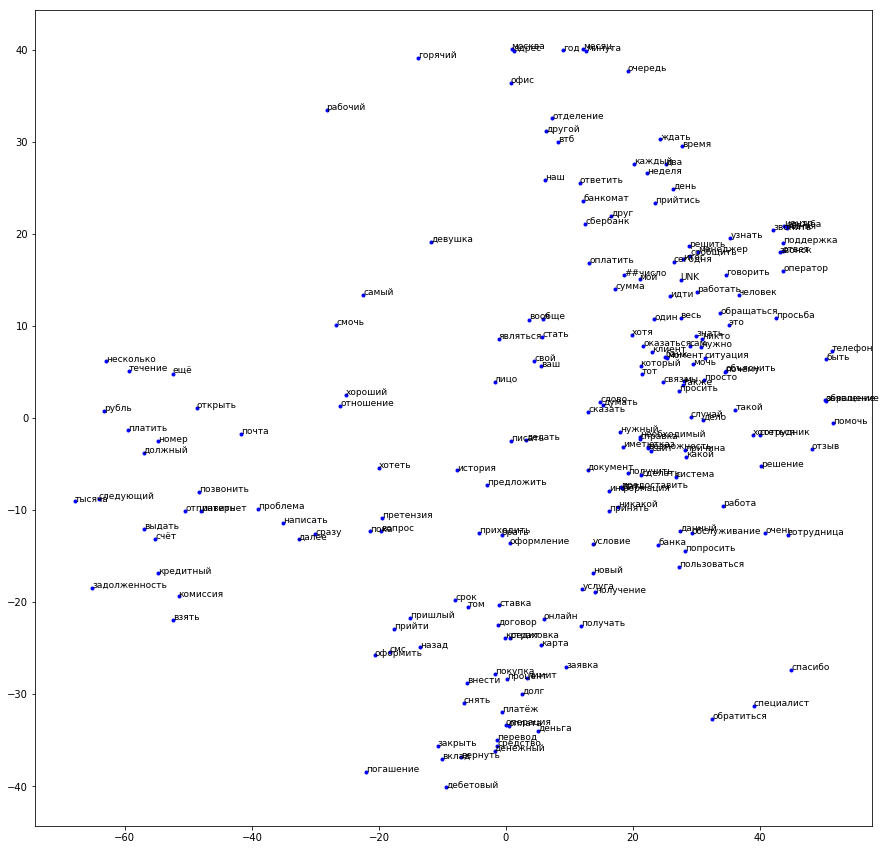

In [ ]:
# из оригинальной тетрадки

for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

In [98]:
torch.save(model, 'model.pt')
torch.save(model.state_dict(), 'model_state_dict.pt')
torch.save(embedding_matrix, 'embedding_matrix.pt')

In [101]:
with open('word2index.json', 'w', encoding='utf-8') as f:
    json.dump(word2index, f, ensure_ascii=False)

*Анна Полянская, БКЛ171*